# Imports

In [1]:
import numpy as np

In [2]:
from scipy.constants import physical_constants

In [3]:
import h5py
import os

In [4]:
from opmd_viewer import OpenPMDTimeSeries
from opmd_viewer.addons import LpaDiagnostics

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')

In [6]:
from IPython.display import HTML, Image

In [7]:
# own module
import postpic as pp

# Paths

In [8]:
base_dir = '/Date1/andrei/runs/fbpic/calder/high_density'
out_dir = 'diags'
h5_dir = 'hdf5'

In [9]:
h5_path = os.path.join(base_dir, out_dir, h5_dir)

In [10]:
timestep = 100 # 100
f_name = os.path.join(h5_path, 'data{:08d}.h5'.format(timestep))
f = h5py.File(f_name, 'r')
fields = '/data/{}/fields'.format(timestep)
handler = f[fields]

In [11]:
f_name

'/Date1/andrei/runs/fbpic/calder/high_density/diags/hdf5/data00000100.h5'

In [12]:
bpath = f['/data/{}'.format(timestep)]

In [13]:
t = bpath.attrs["time"] * bpath.attrs["timeUnitSI"]

In [14]:
t * 1e15 # time in fs

8.1436546679236326

In [15]:
dt = bpath.attrs["dt"] * bpath.attrs["timeUnitSI"] * 1e15 # time step in fs
print('dt = {:05.3f} fs.'.format(dt))

dt = 0.081 fs.


In [16]:
t * 1e15 - timestep * dt # 0.0

0.0

In [17]:
max_iterations = 49100 #

# Density

In [18]:
n_e = 7.5e18 * 1e6 # initial electron density in m^{-3}
q_e = physical_constants['elementary charge'][0] # electron charge in C
m_e = physical_constants['electron mass'][0] # electon mass in Kg

rho = handler['rho']
unit_factor = rho.attrs['unitSI'] / (-q_e * n_e)
print('unit_factor = {} m^3/C'.format(unit_factor))

unit_factor = -8.322012167844344e-07 m^3/C


In [19]:
n_c = 1750e18 * 1e6 # critical electron density in m^{-3}
unit_factor_crit = rho.attrs['unitSI'] / (-q_e * n_c)

In [20]:
c = physical_constants['speed of light in vacuum'][0] # speed of light in m/s
mc2 = m_e * c**2 / (q_e * 1e6) # electron rest energy in MeV: 0.511
print('mc**2 = {:05.3f} MeV.'.format(mc2))

c = c * 1e-9 # speed of light in mu/fs
print('c = {:05.3f} mu/fs.'.format(c))

tstep_to_pos = c * dt # conversion factor in mu

mc**2 = 0.511 MeV.
c = 0.300 mu/fs.


In [21]:
ts_circ = OpenPMDTimeSeries(h5_path)#, check_all_files=False)

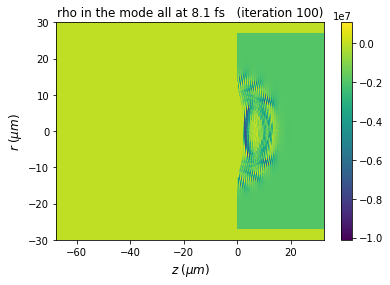

In [22]:
# density in C/m^3
rho, info_rho = ts_circ.get_field(field='rho', iteration=timestep, m='all',
                                 plot=True)

In [23]:
print('dr = {:.3f} mu; dz = {:.3f} mu.'.format(info_rho.dr*1e6, info_rho.dz*1e6))

dr = 0.117 mu; dz = 0.024 mu.


## Animation

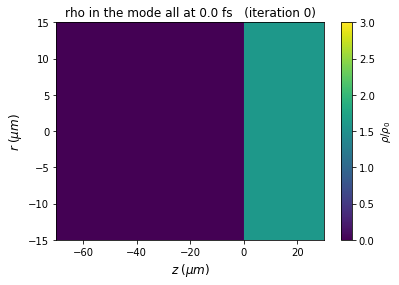

In [24]:
F, info = ts_circ.get_field(field='rho', iteration=0, m='all')

fig, ax = plt.subplots()
# Get the title and labels
ax.set_title("%s in the mode %s at %.1f fs   (iteration %d)"
          % ('rho', 'all', 0, 0),
          fontsize=12)

# Add the name of the axes
ax.set_xlabel('$%s \;(\mu m)$' % info.axes[1], fontsize=12)
ax.set_ylabel('$%s \;(\mu m)$' % info.axes[0], fontsize=12)

ax.set_ylim(-15, 15)

# Plot the data
img_opts = {'origin' : 'lower', 'interpolation' : 'nearest', 'aspect' : 'auto',
            'vmin' : 0, 'vmax' : 3}
img = ax.imshow(F * unit_factor, extent=1.e6 * info.imshow_extent, **img_opts)
cbar = fig.colorbar(img)
cbar.set_label(r'$\rho/\rho_0$')

In [25]:
info.imshow_extent

array([ -7.00000000e-05,   3.00000000e-05,  -3.00000000e-05,
         3.00000000e-05])

In [26]:
def animate(i):
    time_fs = i * dt
    F, info = ts_circ.get_field(field='rho', iteration=i, m='all')
    
    ax.collections = []
    ax.imshow(F * unit_factor, extent=1.e6 * info.imshow_extent, **img_opts)
    
    ax.set_xlim(info.zmin*1e6+40, info.zmax*1e6-20)
    ax.set_title("%s in the mode %s at %.1f fs   (iteration %d)"
          % ('rho', 'all', time_fs, i),
          fontsize=12)

In [27]:
anim = FuncAnimation(
    fig, animate, interval=100, frames=range(0, max_iterations, 100))

In [28]:
anim.save('lwfa.gif', writer='imagemagick', fps=10)

In [29]:
HTML('<img src="lwfa.gif">')

# Laser diagnostics

In [30]:
ts_2d = LpaDiagnostics(h5_path, check_all_files=False)

In [31]:
tstep_v = np.arange(0, max_iterations, 100)

z0_v = np.zeros_like(tstep_v, dtype=np.float32)
omega0_v = np.zeros_like(tstep_v, dtype=np.float32)
a0_v = np.zeros_like(tstep_v, dtype=np.float32)
w0_v = np.zeros_like(tstep_v, dtype=np.float32)
ctau_v = np.zeros_like(tstep_v, dtype=np.float32)

In [32]:
for i, tstep in enumerate(tstep_v):
    z0_v[i], omega0_v[i], a0_v[i], w0_v[i], ctau_v[i] = \
    pp.get_laser_diags(ts_2d, iteration=tstep, units='mufs')

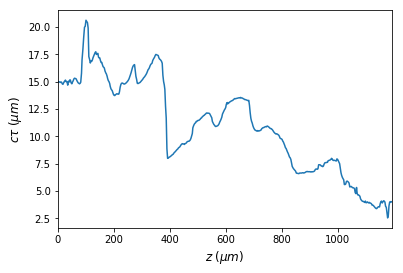

In [33]:
fig, ax = plt.subplots()

ax.plot(z0_v, ctau_v)

ax.set_xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)
ax.set_ylabel(r'$c \tau \;(\mu m)$', fontsize=12)

ax.set_xlim(z0_v[0], z0_v[-1]);

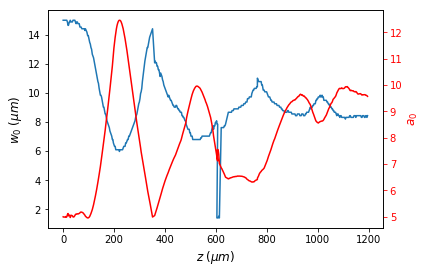

In [34]:
plt.plot(z0_v, w0_v)

plt.ylabel('$%s \;(\mu m)$' % 'w_0', fontsize=12)
plt.xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)

plt.twinx()

plt.plot(z0_v, a0_v, color='red')

plt.ylabel('$%s$' % 'a_0', fontsize=12, color='r')
plt.xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)

plt.tick_params('y', colors='r')

In [35]:
paper_data = np.loadtxt('calder_high_density.csv',delimiter=',')

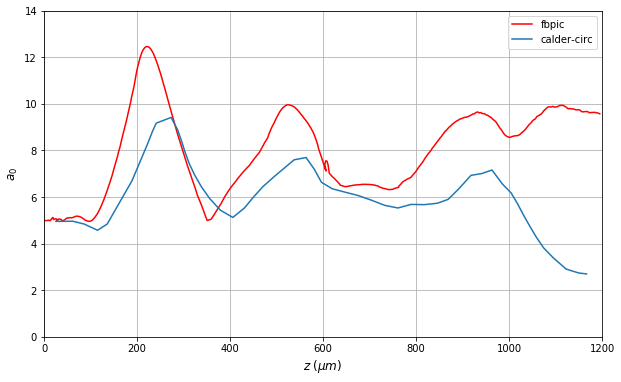

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0,1200)
ax.set_ylim(0,14)

ax.plot(z0_v, a0_v, color='red', label='fbpic')
ax.plot(paper_data[:,0], paper_data[:,1], label='calder-circ')

ax.set_ylabel('$%s$' % 'a_0', fontsize=12)
ax.set_xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)

ax.legend()
ax.grid()

In [44]:
#Image('ramp.png')

In [45]:
#Image('uniform.png')

In [39]:
# Parameters from the histograms
nbins = 100 # Number of bins
Emin = 1. # MeV
Emax = 300. # MeV

iterations = ts_2d.iterations[ts_2d.iterations < max_iterations]

In [40]:
Q_bins = np.zeros( (iterations.size, nbins) )
E_bins = np.linspace( Emin, Emax, nbins+1 )
dE = (Emax - Emin)/nbins
print('dE = {}'.format(dE))

dE = 2.99


In [41]:
for i, tstep in enumerate(iterations):
    ux, uy, uz, w = ts_2d.get_particle(
       ['ux', 'uy', 'uz', 'w'], iteration=tstep )

    E = mc2 * np.sqrt( 1 + ux**2 + uy**2 + uz**2 )  # Energy in MeV
    Q_bins[i, :], _ = np.histogram( E, E_bins, weights = q_e * 1e12 / dE * w )  # weights in pC/MeV

In [42]:
z_min = iterations[0] * tstep_to_pos + 70 # mu
z_max = iterations[-1] * tstep_to_pos + 70 # offset by 70 because left margin is at -70

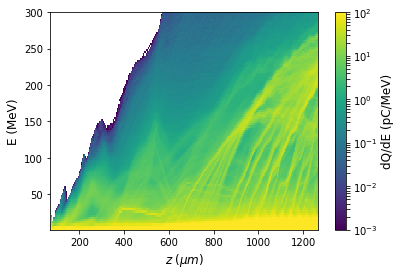

In [43]:
plt.imshow( Q_bins.T, origin='lower',
          extent=[z_min, z_max, Emin, Emax], aspect='auto',
          norm=LogNorm(), vmin=1e-3 , vmax=1e2)
plt.ylabel('E (MeV)', fontsize=12)
plt.xlabel('$%s \;(\mu m)$' % 'z', fontsize=12)
cb = plt.colorbar()
cb.set_label('dQ/dE (pC/MeV)', fontsize=12)